# Ejercicio 1 — Inferencia Bayesiana en una recta con MCMC (Metropolis–Hastings)

**Objetivo:**
1. Generar 50 datos sintéticos con ruido gaussiano: $y_i = a + b\,x_i + \epsilon_i$, $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$  
2. Estimar $a$ y $b$ por inferencia bayesiana con **priors planos** y **gaussianos**, obteniendo la **posterior** por MCMC  
3. Comparar con la solución analítica de **regresión lineal (OLS)**


## 1) Generar datos sintéticos

- Fijo valores "verdaderos" $a_*$, $b_*$ y $\sigma$  
- Creo 50 puntos $x$ y genero $y = a_* + b_* x + \epsilon$ con $\epsilon \sim \mathcal{N}(0,\sigma^2)$  
- Uso una semilla para reproducibilidad


In [1]:
# ======================================================================
# 1) Generar datos sintéticos: y = a_true + b_true * x + ruido gaussiano
# ======================================================================

import numpy as np

rng = np.random.default_rng(42)  # semilla para reproducibilidad

n = 50              # número de puntos
a_true = 2.0        # intercepto verdadero
b_true = -0.7       # pendiente verdadera
sigma_true = 0.5    # desviación estándar del ruido

# Genero los valores de x y y según el modelo lineal con ruido gaussiano
x = np.linspace(-2, 2, n)
y = a_true + b_true * x + rng.normal(0.0, sigma_true, size=n)

print(f"n={n}, a*={a_true}, b*={b_true}, sigma*={sigma_true}")


n=50, a*=2.0, b*=-0.7, sigma*=0.5


## 2) Solución analítica (OLS)

- Armo la matriz de diseño $X = [\mathbf{1},x]$  
- El estimador OLS es $\hat\beta = (X^\top X)^{-1} X^\top y$, con $\hat\beta=(a_{\text{OLS}},b_{\text{OLS}})$  
- Calculo la varianza residual y la incertidumbre de $a$ y $b$


In [2]:
# ======================================================================
# 2) Solución analítica (Regresión Lineal - OLS)
# ======================================================================
# El método de mínimos cuadrados ordinarios (OLS) busca los parámetros
# que minimizan la suma de los residuos al cuadrado.
# β_hat = (X^T X)^(-1) X^T y

# Armo la matriz de diseño: primera columna de 1's para el término independiente
X = np.column_stack([np.ones_like(x), x])

# Calculo los parámetros a y b por OLS
beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
a_ols, b_ols = beta_hat

# Calculo los residuos y la varianza residual
res = y - (a_ols + b_ols * x)
sigma2_hat = (res @ res) / (n - 2)

# Estimo la covarianza y los errores estándar de a y b
cov_beta = sigma2_hat * np.linalg.inv(X.T @ X)
sa_ols, sb_ols = np.sqrt(np.diag(cov_beta))

print(f"OLS: a = {a_ols:.3f} ± {sa_ols:.3f} | b = {b_ols:.3f} ± {sb_ols:.3f}")


OLS: a = 2.046 ± 0.054 | b = -0.643 ± 0.046


## 3) Likelihood y priors

- **Supuesto de ruido:** $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$ independiente →  

  $$\log L(a,b) = -\tfrac12 \sum_i \left(\frac{y_i - (a + b x_i)}{\sigma}\right)^2 + \text{cte}$$

- **Prior plano** (uniforme truncado): probabilidad constante en un rango amplio ($-\infty$ fuera)  
- **Prior gaussiano** independiente para $a$ y $b$: centra y "regulariza" hacia sus medias


In [3]:
# ======================================================================
# 3) Definición de la función de Likelihood y de los priors
# ======================================================================
# Asumo errores gaussianos independientes: ε_i ~ N(0, σ^2)
# => log(L) ∝ -0.5 * sum(((y - (a + b x))/σ)^2)
# Los priors reflejan el conocimiento previo sobre los parámetros.

sigma_obs = sigma_true  # en este ejercicio considero σ conocida

# --- Likelihood ---
def log_likelihood(a, b, x, y, sigma):
    """Calcula el log-likelihood suponiendo errores gaussianos"""
    resid = y - (a + b * x)
    return -0.5 * np.sum((resid / sigma)**2)

# --- Prior plano (uniforme) ---
def log_prior_uniform(a, b, a_min=-50, a_max=50, b_min=-50, b_max=50):
    """Prior uniforme truncado en un rango amplio"""
    if (a_min <= a <= a_max) and (b_min <= b <= b_max):
        return 0.0
    return -np.inf  # fuera del rango, probabilidad nula

# --- Prior gaussiano ---
def log_prior_gaussian(a, b, mu_a=0.0, s_a=5.0, mu_b=0.0, s_b=5.0):
    """Prior gaussiano independiente para a y b"""
    return -0.5*((a - mu_a)/s_a)**2 - 0.5*((b - mu_b)/s_b)**2


## 4) Posterior y muestreo MCMC (Metropolis–Hastings)

- $\log p_{\text{post}} = \log L + \log p_{\text{prior}}$  
- Propuesta simétrica: $a' = a + \mathcal{N}(0,\text{step}_a^2)$, $b' = b + \mathcal{N}(0,\text{step}_b^2)$  
- Acepto si $\log u < \log p' - \log p$ (con $u \sim U[0,1]$)


In [4]:
# ======================================================================
# 4) Definición de la posterior y del algoritmo Metropolis–Hastings
# ======================================================================
# La posterior es proporcional a: posterior ∝ likelihood × prior
# Uso el log para evitar underflow numérico:
# log(posterior) = log(L) + log(prior)
# En el algoritmo Metropolis-Hastings propongo un nuevo punto (a', b')
# y decido si aceptarlo comparando su probabilidad relativa.

def log_posterior(a, b, x, y, sigma, prior_type="uniform"):
    """Calcula el log de la probabilidad posterior"""
    ll = log_likelihood(a, b, x, y, sigma)
    lp = log_prior_uniform(a, b) if prior_type=="uniform" else log_prior_gaussian(a, b)
    return ll + lp


def mh_sampler(x, y, sigma, n_steps=20000, burnin=5000, step_a=0.05, step_b=0.05, prior_type="uniform"):
    """Implementa el algoritmo de Metropolis-Hastings para MCMC"""
    # Inicializo los parámetros
    a, b = 0.0, 0.0
    logp = log_posterior(a, b, x, y, sigma, prior_type)
    samples = np.zeros((n_steps, 2))
    acc = 0  # contador de aceptaciones

    for t in range(n_steps):
        # Propongo un nuevo punto (a', b') con saltos gaussianos simétricos
        a_p = a + np.random.normal(0, step_a)
        b_p = b + np.random.normal(0, step_b)

        # Calculo la nueva posterior
        logp_p = log_posterior(a_p, b_p, x, y, sigma, prior_type)

        # Regla de aceptación: acepto si aumenta la probabilidad
        # o con probabilidad e^(Δlogp) si disminuye
        if np.log(np.random.uniform()) < (logp_p - logp):
            a, b, logp = a_p, b_p, logp_p
            acc += 1

        samples[t] = [a, b]

    # Fracción de pasos aceptados (indica la eficiencia del muestreo)
    acc_rate = acc / n_steps

    # Descarta el "burn-in": pasos iniciales antes de converger
    post = samples[burnin:]
    return samples, post, acc_rate



## 5) MCMC con prior plano y posterior

Genero la cadena, muestro la tasa de aceptación y los percentiles 16–50–84 de $a$ y $b$ (≈ intervalos 1σ).


In [5]:
# ======================================================================
# 5) MCMC con prior plano
# ======================================================================

samples_u, post_u, acc_u = mh_sampler(x, y, sigma_obs, prior_type="uniform")

# Calculo percentiles 16-50-84 para estimar la media y dispersión posterior
a_ci_u = np.percentile(post_u[:,0], [16,50,84])
b_ci_u = np.percentile(post_u[:,1], [16,50,84])

print(f"[Prior plano] tasa de aceptación ≈ {acc_u:.2f}")
print(f"a (p16,p50,p84): {a_ci_u}")
print(f"b (p16,p50,p84): {b_ci_u}")



[Prior plano] tasa de aceptación ≈ 0.64
a (p16,p50,p84): [1.97299355 2.04467618 2.12043644]
b (p16,p50,p84): [-0.70245865 -0.64080786 -0.5812067 ]


## 6) MCMC con prior gaussiano y posterior


In [6]:
# ======================================================================
# 6) MCMC con prior gaussiano
# ======================================================================

samples_g, post_g, acc_g = mh_sampler(x, y, sigma_obs, prior_type="gaussian")

a_ci_g = np.percentile(post_g[:,0], [16,50,84])
b_ci_g = np.percentile(post_g[:,1], [16,50,84])

print(f"[Prior gaussiano] tasa de aceptación ≈ {acc_g:.2f}")
print(f"a (p16,p50,p84): {a_ci_g}")
print(f"b (p16,p50,p84): {b_ci_g}")



[Prior gaussiano] tasa de aceptación ≈ 0.64
a (p16,p50,p84): [1.97439079 2.04211275 2.11297149]
b (p16,p50,p84): [-0.70195768 -0.64319588 -0.58205581]


## 7) Comparación con OLS

Muestro:

- Verdaderos $(a_*,b_*)$  
- OLS con incertidumbre  
- Medianas de las posteriores para ambos priors


In [7]:
# ======================================================================
# 7) Comparación de resultados
# ======================================================================
# Se comparan los parámetros verdaderos, los obtenidos por OLS,
# y las medianas (p50) de las posteriores obtenidas con MCMC.

a_med_u, b_med_u = np.median(post_u[:,0]), np.median(post_u[:,1])
a_med_g, b_med_g = np.median(post_g[:,0]), np.median(post_g[:,1])

print("--- Comparación final ---")
print(f"Verdadero: a*={a_true:.3f}, b*={b_true:.3f}")
print(f"OLS:       a={a_ols:.3f} ± {sa_ols:.3f}, b={b_ols:.3f} ± {sb_ols:.3f}")
print(f"MCMC prior plano:     a={a_med_u:.3f}, b={b_med_u:.3f}")
print(f"MCMC prior gaussiano: a={a_med_g:.3f}, b={b_med_g:.3f}")



--- Comparación final ---
Verdadero: a*=2.000, b*=-0.700
OLS:       a=2.046 ± 0.054, b=-0.643 ± 0.046
MCMC prior plano:     a=2.045, b=-0.641
MCMC prior gaussiano: a=2.042, b=-0.643


## 8) Visualización final: datos y rectas comparadas

- Puntos: datos sintéticos $(x_i, y_i)$  
- Línea “Verdadera”: $y = a_* + b_* x$  
- Línea “OLS”: $y = a_{\text{OLS}} + b_{\text{OLS}} x$  
- Línea “MCMC (prior plano)”: $y = \text{mediana}(a) + \text{mediana}(b)\, x$  
- Línea “MCMC (prior gaussiano)”: $y = \text{mediana}(a) + \text{mediana}(b)\, x$


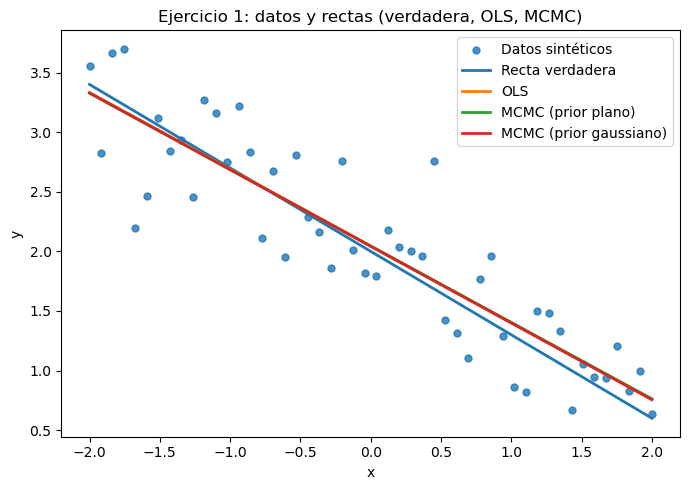

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------
# Preparo grilla de x para dibujar las rectas suavemente
# ----------------------------------------------------------
xx = np.linspace(x.min(), x.max(), 400)

# Recta verdadera
yy_true = a_true + b_true * xx

# Recta OLS
yy_ols = a_ols + b_ols * xx

# Recta posterior (prior plano): uso las medianas ya calculadas
yy_mcmc_u = a_med_u + b_med_u * xx

# Recta posterior (prior gaussiano): uso las medianas ya calculadas
yy_mcmc_g = a_med_g + b_med_g * xx

# ----------------------------------------------------------
# Figura con los datos y las cuatro rectas
# ----------------------------------------------------------
plt.figure(figsize=(7, 5))

# Datos sintéticos
plt.scatter(x, y, s=25, alpha=0.8, label="Datos sintéticos")

# Líneas de referencia/estimación
plt.plot(xx, yy_true, linewidth=2.0, label="Recta verdadera")
plt.plot(xx, yy_ols, linewidth=2.0, label="OLS")
plt.plot(xx, yy_mcmc_u, linewidth=2.0, label="MCMC (prior plano)")
plt.plot(xx, yy_mcmc_g, linewidth=2.0, label="MCMC (prior gaussiano)")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Ejercicio 1: datos y rectas (verdadera, OLS, MCMC)")
plt.legend()
plt.tight_layout()
plt.show()


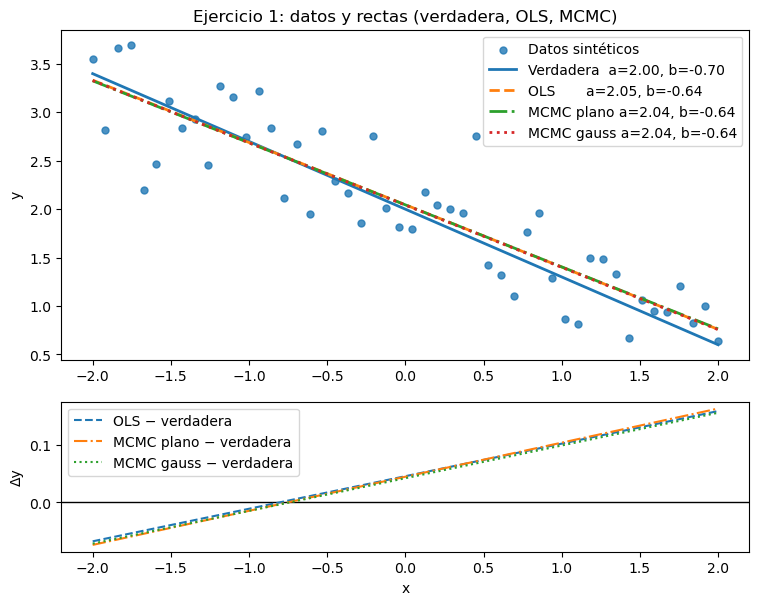

In [9]:
import matplotlib.pyplot as plt
import numpy as np

xx = np.linspace(x.min(), x.max(), 400)
yy_true = a_true + b_true * xx
yy_ols  = a_ols  + b_ols  * xx
yy_u    = a_med_u + b_med_u * xx
yy_g    = a_med_g + b_med_g * xx

fig = plt.figure(figsize=(8,6))

# --- Panel superior: datos + rectas ---
ax1 = fig.add_axes([0.12, 0.42, 0.86, 0.55])
ax1.scatter(x, y, s=25, alpha=0.8, label="Datos sintéticos")
ax1.plot(xx, yy_true,  linestyle="-",  linewidth=2.0, label=f"Verdadera  a={a_true:.2f}, b={b_true:.2f}")
ax1.plot(xx, yy_ols,   linestyle="--", linewidth=2.0, label=f"OLS       a={a_ols:.2f}, b={b_ols:.2f}")
ax1.plot(xx, yy_u,     linestyle="-.", linewidth=2.0, label=f"MCMC plano a={a_med_u:.2f}, b={b_med_u:.2f}")
ax1.plot(xx, yy_g,     linestyle=":",  linewidth=2.0, label=f"MCMC gauss a={a_med_g:.2f}, b={b_med_g:.2f}")
ax1.set_ylabel("y")
ax1.set_title("Ejercicio 1: datos y rectas (verdadera, OLS, MCMC)")
ax1.legend(loc="upper right")

# --- Panel inferior: diferencias respecto a la verdadera ---
ax2 = fig.add_axes([0.12, 0.10, 0.86, 0.25], sharex=ax1)
ax2.axhline(0, color="k", linewidth=1)
ax2.plot(xx, yy_ols - yy_true,  "--", label="OLS − verdadera")
ax2.plot(xx, yy_u   - yy_true, "-.", label="MCMC plano − verdadera")
ax2.plot(xx, yy_g   - yy_true, ":",  label="MCMC gauss − verdadera")
ax2.set_xlabel("x")
ax2.set_ylabel("Δy")
ax2.legend(loc="upper left")
plt.show()
